**Install Required Libraries**

In [ ]:
!pip install torchdiffeq kagglehub requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

**Import Libraries**

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import pandas as pd
import numpy as np
import requests
import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Load Bitcoin Historical Data**

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load OHLCV data
bitcoin_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mczielinski/bitcoin-historical-data",
    "btcusd_1-min_data.csv"  # replace with actual file name
)

<ipython-input-3-1bb2b0e86653>:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  bitcoin_df = kagglehub.load_dataset(


100%|██████████| 351M/351M [00:01<00:00, 242MB/s]


In [ ]:
print(bitcoin_df.columns)
bitcoin_df.head(10)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0
5,1.325412e+09,4.58,4.58,4.58,4.58,0.0
6,1.325412e+09,4.58,4.58,4.58,4.58,0.0
7,1.325412e+09,4.58,4.58,4.58,4.58,0.0
8,1.325413e+09,4.58,4.58,4.58,4.58,0.0
9,1.325413e+09,4.58,4.58,4.58,4.58,0.0


In [ ]:
import pandas as pd

# Parse datetime and set as index
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['Timestamp'], unit='s')
bitcoin_df.set_index('datetime', inplace=True)

# Drop rows with missing prices (if any)
bitcoin_df.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)

# Resample to daily OHLCV
daily_df = bitcoin_df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Drop days where price is completely missing
daily_df.dropna(inplace=True)

daily_df.head(10)


,Open,High,Low,Close,Volume
datetime,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742
2012-01-06,6.42,6.90,6.40,6.40,55.855834
2012-01-07,6.40,6.80,6.00,6.80,2.795858
2012-01-08,6.80,6.90,6.80,6.90,4.000000
2012-01-09,6.90,7.00,6.36,6.48,64.869323


**Fetch Fear-and-Greed Index Data**

In [ ]:
# def fetch_fear_and_greed_index(limit=0):
#     url = f"https://api.alternative.me/fng/?limit={limit}&format=json"
#     response = requests.get(url)
#     data = response.json()['data']

#     records = []
#     for d in data:
#         ts = datetime.datetime.fromtimestamp(int(d['timestamp']))
#         records.append({'date': ts.date(), 'fgi': int(d['value'])})

#     fgi_df = pd.DataFrame(records)
#     fgi_df = fgi_df.drop_duplicates(subset='date').sort_values('date')
#     fgi_df['date'] = pd.to_datetime(fgi_df['date'])
#     fgi_df.set_index('date', inplace=True)
#     return fgi_df

# fgi_df = fetch_fear_and_greed_index(limit=0)  # all available
# fgi_df.head(10)


In [ ]:
# prompt: clean nas from the fgi and fill it with the previous value

# fgi_df['fgi'] = fgi_df['fgi'].ffill()

**Merge & Scale Datasets**

In [ ]:
# Ensure the datetime index is timezone-aware
daily_df.index = daily_df.index.tz_localize('UTC')

# ✅ Filter to only include data from January 1, 2022 onwards
daily_df = daily_df[daily_df.index >= '2018-02-01']

# Drop rows with NaNs
daily_df.dropna(inplace=True)

# Normalize all features (excluding FGI)
features = ['Open', 'High', 'Low', 'Close']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=daily_df.index)

# Target: next-day Close
scaled_df['Target'] = scaled_df['Close'].shift(-1)
scaled_df.dropna(inplace=True)

scaled_df.head(10)


<ipython-input-8-fcf8cbe7556c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_df.dropna(inplace=True)


,Open,High,Low,Close,Target
datetime,,,,,
2018-02-01 00:00:00+00:00,-0.830146,-0.833263,-0.862768,-0.868183,-0.882843
2018-02-02 00:00:00+00:00,-0.867968,-0.868451,-0.908725,-0.882843,-0.852520
2018-02-03 00:00:00+00:00,-0.883730,-0.860706,-0.887760,-0.852520,-0.893306
2018-02-04 00:00:00+00:00,-0.852111,-0.858962,-0.887045,-0.893306,-0.946834
2018-02-05 00:00:00+00:00,-0.893122,-0.898642,-0.937920,-0.946834,-0.936132
2018-02-06 00:00:00+00:00,-0.946719,-0.932929,-0.974239,-0.936132,-0.895646
2018-02-07 00:00:00+00:00,-0.935715,-0.890044,-0.926592,-0.895646,-0.896425
2018-02-08 00:00:00+00:00,-0.895465,-0.890215,-0.911876,-0.896425,-0.881254
2018-02-09 00:00:00+00:00,-0.896267,-0.885224,-0.903803,-0.881254,-0.892541


**Define Neural ODE Architecture**

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

# ODE function representing dH/dt = f(H, t)
class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, h):
        return self.net(h)

# Neural ODE wrapper
class NeuralODE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func

    def forward(self, h0, t):
        return odeint(self.ode_func, h0, t)  # Output shape: [time_steps, batch_size, dim]


**Prepare the Dataset (Sliding Window Format)**

In [ ]:
import numpy as np

# Parameters
n_steps = 30  # How many days of history to feed
features = ['Open', 'High', 'Low', 'Close']  # Removed 'fgi'
target_col = 'Target'

# Convert to numpy
data = scaled_df[features].values
target = scaled_df[target_col].values

# Prepare sequences and targets
X, y = [], []
for i in range(len(data) - n_steps):
    X.append(data[i:i+n_steps])
    y.append(target[i+n_steps])

X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}, Target shape: {y.shape}")


Input shape: (2650, 30, 4), Target shape: (2650,)


**Convert to PyTorch Tensors**

In [ ]:
# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)         # [batch, time, features]
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # [batch, 1]


**Train-Test Split**

In [ ]:
# New 70/15/15 split
train_end = int(0.7 * len(X_tensor))
val_end = int(0.85 * len(X_tensor))

X_train, X_val, X_test = X_tensor[:train_end], X_tensor[train_end:val_end], X_tensor[val_end:]
y_train, y_val, y_test = y_tensor[:train_end], y_tensor[train_end:val_end], y_tensor[val_end:]


**Define Full Neural ODE Model for Regression**

In [ ]:
class ODEBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ODEBlock, self).__init__()
        self.ode_func = ODEFunc(input_dim, hidden_dim)
        self.ode = NeuralODE(self.ode_func)

    def forward(self, x):
        # x: [batch, time, features]
        batch_size, time_steps, input_dim = x.size()

        # Transpose for odeint: [time, batch, features]
        x = x.transpose(0, 1)

        # Initial state: first time step
        h0 = x[0]

        # Time vector: assume uniform time intervals
        t = torch.linspace(0, 1, steps=time_steps).to(x.device)

        out = self.ode(h0, t)  # [time, batch, features]
        final_state = out[-1]  # Last time step
        return final_state  # [batch, features]

class NeuralODERegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralODERegressor, self).__init__()
        self.odeblock = ODEBlock(input_dim, hidden_dim)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        h_last = self.odeblock(x)
        out = self.fc(h_last)
        return out


**Training Loopo**

In [ ]:
# Hyperparameters
input_dim = X_train.shape[2]
hidden_dim = 16
lr = 1e-4
epochs = 2000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
neural_ode_model = NeuralODERegressor(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(neural_ode_model.parameters(), lr=lr)
criterion = nn.MSELoss()

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Send validation tensors to device
X_val, y_val = X_val.to(device), y_val.to(device)

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None


for epoch in range(epochs):
    neural_ode_model.train()
    optimizer.zero_grad()

    output = neural_ode_model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 5 == 0 or epoch == 0:
        neural_ode_model.eval()
        with torch.no_grad():
            val_pred = neural_ode_model(X_val)
            val_loss = criterion(val_pred, y_val)
            test_pred = neural_ode_model(X_test)
            test_loss = criterion(test_pred, y_test)
            val_losses.append(val_loss.item())

            # Save model if it's the best so far
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = neural_ode_model.state_dict()

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Load the best model based on validation loss
neural_ode_model.load_state_dict(best_model_state)


Epoch 1/2000 - Train Loss: 0.5720, Val Loss: 0.3542, Test Loss: 0.3042
Epoch 5/2000 - Train Loss: 0.5624, Val Loss: 0.3510, Test Loss: 0.3013
Epoch 10/2000 - Train Loss: 0.5505, Val Loss: 0.3472, Test Loss: 0.2977
Epoch 15/2000 - Train Loss: 0.5388, Val Loss: 0.3433, Test Loss: 0.2943
Epoch 20/2000 - Train Loss: 0.5274, Val Loss: 0.3396, Test Loss: 0.2911
Epoch 25/2000 - Train Loss: 0.5162, Val Loss: 0.3359, Test Loss: 0.2881
Epoch 30/2000 - Train Loss: 0.5052, Val Loss: 0.3324, Test Loss: 0.2853
Epoch 35/2000 - Train Loss: 0.4945, Val Loss: 0.3288, Test Loss: 0.2826
Epoch 40/2000 - Train Loss: 0.4840, Val Loss: 0.3254, Test Loss: 0.2800
Epoch 45/2000 - Train Loss: 0.4738, Val Loss: 0.3220, Test Loss: 0.2776
Epoch 50/2000 - Train Loss: 0.4638, Val Loss: 0.3187, Test Loss: 0.2754
Epoch 55/2000 - Train Loss: 0.4540, Val Loss: 0.3154, Test Loss: 0.2733
Epoch 60/2000 - Train Loss: 0.4445, Val Loss: 0.3122, Test Loss: 0.2714
Epoch 65/2000 - Train Loss: 0.4351, Val Loss: 0.3091, Test Loss: 0

<All keys matched successfully>

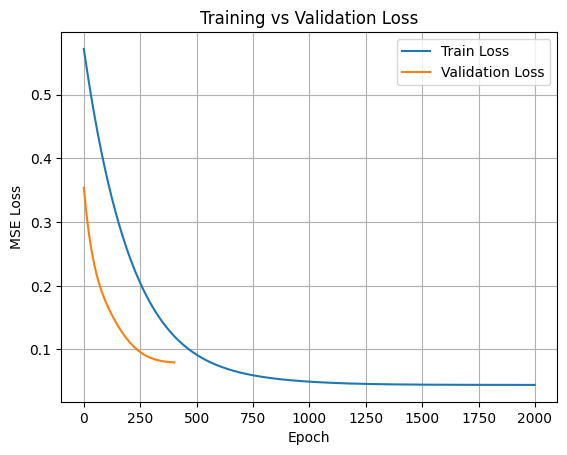

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


**Define a Rolling Forecast Function**

In [ ]:
def rolling_forecast(model, initial_sequence, n_days=30):
    """
    Performs recursive forecasting for n_days based on initial_sequence.
    - model: trained NeuralODERegressor
    - initial_sequence: shape [1, time_steps, features]
    - returns: array of predictions
    """
    model.eval()
    input_seq = initial_sequence.clone().detach()  # clone to avoid modifying original
    predictions = []

    for _ in range(n_days):
        with torch.no_grad():
            pred = model(input_seq)  # shape: [1, 1]
            predictions.append(pred.item())

        # Append prediction as new "Close", keep others unchanged (optional trick)
        # Here, we update only the 'Close' column (index 3)
        new_day = input_seq[:, -1, :].clone()
        new_day[:, 3] = pred  # update Close
        input_seq = torch.cat([input_seq[:, 1:, :], new_day.unsqueeze(1)], dim=1)

    return predictions


**Select a Starting Point (last sequence in X_test)**


In [ ]:
# Pick the last known sequence from test set
initial_seq = X_test[-1].unsqueeze(0).to(device)  # shape: [1, n_steps, features]

# Generate 30-day forecast
forecast_30 = rolling_forecast(neural_ode_model, initial_seq, n_days=30)


In [ ]:
# Convert forecast_30 to real price (USD)
forecast_full = np.zeros((30, 4))
forecast_full[:, 3] = forecast_30  # only 'Close'

forecast_real = scaler.inverse_transform(forecast_full)[:, 3]

# Get true values from real test data
true_30 = scaled_df['Close'].iloc[-30:]
true_full = np.zeros((30, 4))
true_full[:, 3] = true_30
true_real = scaler.inverse_transform(true_full)[:, 3]

# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE first, then take the square root for RMSE
neural_ode_30_mse = mean_squared_error(true_real, forecast_real)
neural_ode_30_rmse = np.sqrt(neural_ode_30_mse) # Manually compute RMSE
neural_ode_30_mae = mean_absolute_error(true_real, forecast_real)
print(f"Neural ODE (30-day) RMSE: {neural_ode_30_rmse:.2f}, MAE: {neural_ode_30_mae:.2f}")

Neural ODE (30-day) RMSE: 3407.43, MAE: 2755.43


**Plot the Rolling Forecast**

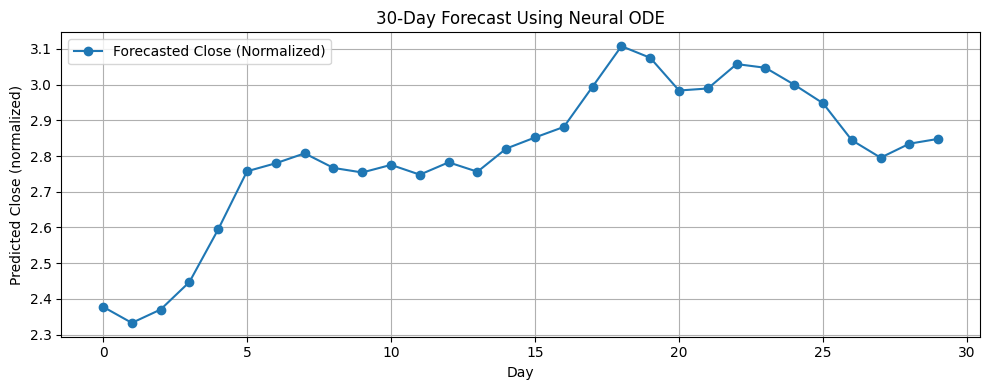

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(forecast_30, label='Forecasted Close (Normalized)', marker='o')
plt.title('30-Day Forecast Using Neural ODE')
plt.xlabel('Day')
plt.ylabel('Predicted Close (normalized)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Evaluate Predictions**

In [ ]:
test_pred = neural_ode_model(X_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()


**RMSE (Root Mean Squared Error)**

**MAE (Mean Absolute Error)**

**MDA (Mean Directional Accuracy)**

**Optional: Visualize Predictions**

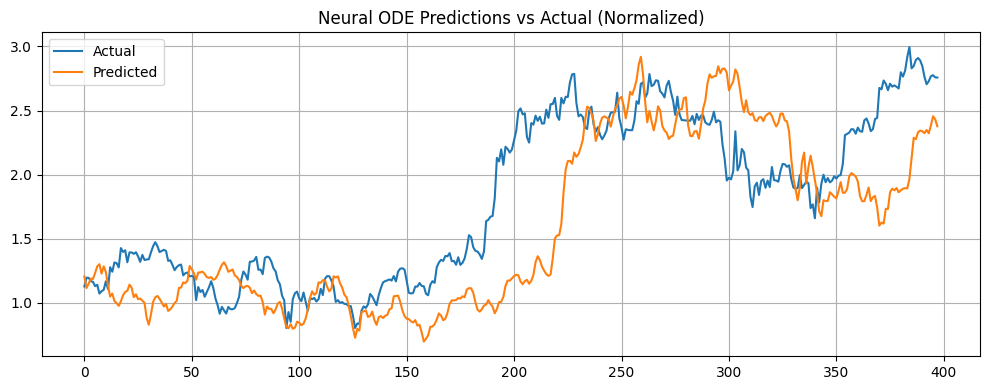

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.title('Neural ODE Predictions vs Actual (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


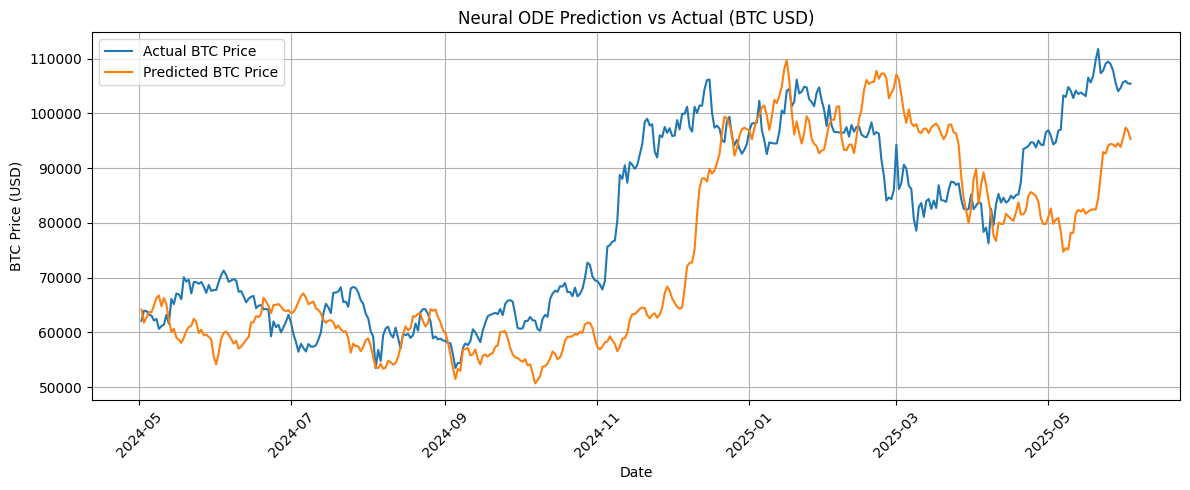

In [ ]:
# Inverse transform predictions (assuming 'Close' is 4th column in original features)
y_true_full = np.zeros((len(y_true), 4))  # Dummy array for all 5 features
y_true_full[:, 3] = y_true.flatten()     # Assign predicted Close
y_pred_full = np.zeros((len(test_pred), 4))
y_pred_full[:, 3] = test_pred.flatten()

y_true_real = scaler.inverse_transform(y_true_full)[:, 3]
y_pred_real = scaler.inverse_transform(y_pred_full)[:, 3]

# Reconstruct the actual dates for the test set
test_dates = scaled_df.index[-len(y_true):]  # Or use merged_df if you prefer original unscaled index

# Plot with real dates on X-axis
plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_true_real, label='Actual BTC Price')
plt.plot(test_dates, y_pred_real, label='Predicted BTC Price')
plt.title('Neural ODE Prediction vs Actual (BTC USD)')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print(len(test_dates), len(y_pred_real))  # Should be equal

398 398


In [ ]:
# Denormalize y_true and test_pred
neural_ode_y_true_full = np.zeros((len(y_true), 4))  # 5 features
neural_ode_test_pred_full = np.zeros((len(test_pred), 4))

neural_ode_y_true_full[:, 3] = y_true.flatten()  # 'Close' column
# test_pred is already a numpy array, no need to detach or convert to numpy again
neural_ode_test_pred_full[:, 3] = test_pred.flatten()

neural_ode_y_true_real = scaler.inverse_transform(neural_ode_y_true_full)[:, 3]
neural_ode_test_pred_real = scaler.inverse_transform(neural_ode_test_pred_full)[:, 3]

# Recalculate RMSE/MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

neural_ode_rmse = np.sqrt(mean_squared_error(neural_ode_y_true_real, neural_ode_test_pred_real))
neural_ode_mae = mean_absolute_error(neural_ode_y_true_real, neural_ode_test_pred_real)

**LSTM Model Class**

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)


    def forward(self, x):
        out, _ = self.lstm(x)  # out: [batch, time, hidden_dim]
        last_output = out[:, -1, :]  # Take the last time step's output
        return self.fc(last_output)  # Predict final value


**Train and Evaluate (LSTM)**

In [ ]:
input_dim = X_train.shape[2]
hidden_dim = 256
epochs = 500
lr = 1e-3

lstm_model = LSTMRegressor(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

# Reset best_val_loss and best_model_state specifically for the LSTM
best_val_loss_lstm = float('inf')
best_model_state_lstm = None

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    pred = lstm_model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    lstm_model.eval()
    with torch.no_grad():
        val_pred = lstm_model(X_val)
        val_loss = criterion(val_pred, y_val)
        val_losses.append(val_loss.item())

        # Save best model
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = lstm_model.state_dict()

    if (epoch + 1) % 5 == 0 or epoch == 0:
        test_pred = lstm_model(X_test)
        test_loss = criterion(test_pred, y_test)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

lstm_model.load_state_dict(best_model_state)



Epoch 1/500 - Train Loss: 0.5496, Val Loss: 0.3377, Test Loss: 3.4847
Epoch 5/500 - Train Loss: 0.2581, Val Loss: 0.2662, Test Loss: 2.4655
Epoch 10/500 - Train Loss: 0.0740, Val Loss: 0.1905, Test Loss: 1.6200
Epoch 15/500 - Train Loss: 0.0626, Val Loss: 0.0926, Test Loss: 0.8426
Epoch 20/500 - Train Loss: 0.0086, Val Loss: 0.0162, Test Loss: 0.0745
Epoch 25/500 - Train Loss: 0.0137, Val Loss: 0.0078, Test Loss: 0.1023
Epoch 30/500 - Train Loss: 0.0077, Val Loss: 0.0172, Test Loss: 0.3007
Epoch 35/500 - Train Loss: 0.0078, Val Loss: 0.0160, Test Loss: 0.3102
Epoch 40/500 - Train Loss: 0.0058, Val Loss: 0.0092, Test Loss: 0.2339
Epoch 45/500 - Train Loss: 0.0049, Val Loss: 0.0072, Test Loss: 0.1929
Epoch 50/500 - Train Loss: 0.0052, Val Loss: 0.0072, Test Loss: 0.1758
Epoch 55/500 - Train Loss: 0.0047, Val Loss: 0.0064, Test Loss: 0.1640
Epoch 60/500 - Train Loss: 0.0047, Val Loss: 0.0066, Test Loss: 0.1725
Epoch 65/500 - Train Loss: 0.0045, Val Loss: 0.0078, Test Loss: 0.1879
Epoch 70

<All keys matched successfully>

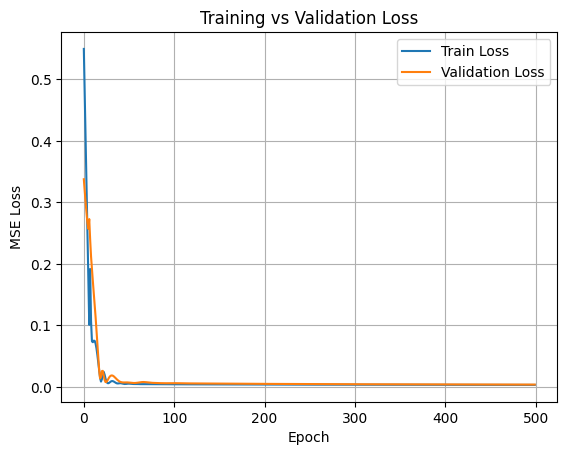

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


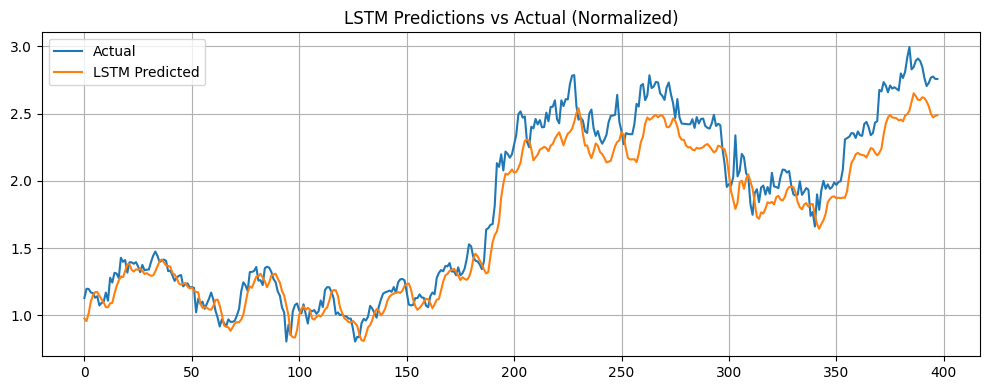

In [ ]:
# Assuming lstm_model is your trained LSTM and X_test, y_test are your test tensors

# Get predictions from LSTM model
lstm_pred = lstm_model(X_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual')
plt.plot(lstm_pred, label='LSTM Predicted')
plt.title('LSTM Predictions vs Actual (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# def rolling_forecast_lstm(model, initial_sequence, n_days=30):
#     """
#     Performs recursive forecasting for n_days using LSTM.
#     :param model: trained LSTMRegressor model
#     :param initial_sequence: shape [1, time_steps, features]
#     :return: list of predicted Close values (normalized)
#     """
#     model.eval()
#     input_seq = initial_sequence.clone().detach()
#     predictions = []

#     for _ in range(n_days):
#         print(input_seq)
#         with torch.no_grad():
#             pred = model(input_seq)  # shape: [1, 1]
#             predictions.append(pred.item())

#         # Prepare next input sequence
#         new_day = input_seq[:, -1, :].clone()
#         new_day[:, 0] = pred  # Open = predicted Close
#         new_day[:, 1] = pred  # High = predicted Close
#         new_day[:, 2] = pred  # Low = predicted Close
#         new_day[:, 3] = pred  # Close = predicted Close
#         # fgi stays constant or can be shifted (optional)
#         input_seq = torch.cat([input_seq[:, 1:, :], new_day.unsqueeze(1)], dim=1)

#     return predictions


In [ ]:
# initial_seq_lstm = X_test[-1].unsqueeze(0).to(device)
# forecast_30_lstm = rolling_forecast_lstm(lstm_model, initial_seq_lstm, n_days=30)


In [ ]:
# lstm_forecast_full = np.zeros((30, 4))
# lstm_forecast_full[:, 3] = forecast_30_lstm
# lstm_forecast_real = scaler.inverse_transform(lstm_forecast_full)[:, 3]

# # Calculate MSE first, then take the square root for RMSE
# lstm_30_mse = mean_squared_error(true_real, lstm_forecast_real)
# lstm_30_rmse = np.sqrt(lstm_30_mse) # Manually compute RMSE
# lstm_30_mae = mean_absolute_error(true_real, lstm_forecast_real)
# print(f"LSTM (30-day) RMSE: {lstm_30_rmse:.2f}, MAE: {lstm_30_mae:.2f}")


In [ ]:
# lstm_model.eval()
# with torch.no_grad():
#     lstm_test_pred = lstm_model(X_test).detach().cpu().numpy()
#     lstm_y_true = y_test.detach().cpu().numpy()

# lstm_rmse = np.sqrt(mean_squared_error(lstm_y_true, lstm_test_pred))
# lstm_mae = mean_absolute_error(lstm_y_true, lstm_test_pred)

# print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")


**ARIMAX**

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Use raw Close as target and fgi as exogenous input
# raw_df = merged_df[['Close', 'fgi']].copy().dropna()
# raw_df.index = pd.DatetimeIndex(raw_df.index)
# raw_df = raw_df.asfreq('D').dropna()


# # Train/test split
# train_size = int(0.85 * len(raw_df))
# train_data = raw_df.iloc[:train_size]
# test_data = raw_df.iloc[train_size:]

# # Fit ARIMAX
# model = SARIMAX(train_data['Close'], exog=train_data[['fgi']], order=(5, 1, 0))  # order can be tuned
# arimax_fit = model.fit(disp=False)


In [ ]:
# # from statsmodels.tsa.statespace.sarimax import SARIMAX

# # def forecast_arimax_once(endog_train, exog_train, exog_forecast,
# #                          model_order=(1, 1, 1), seasonal_order=(1, 0, 1, 7),
# #                          n_days=30):
# #     """
# #     Forecast 30 days using ARIMAX without retraining on each step.
# #     :param endog_train: pd.Series of Close prices (training set)
# #     :param exog_train: pd.DataFrame of FGI for training
# #     :param exog_forecast: pd.DataFrame of FGI for the forecast period (30 rows)
# #     :return: List of predicted Close prices (length = 30)
# #     """
# #     model = SARIMAX(
# #         endog=endog_train,
# #         exog=exog_train,
# #         order=model_order,
# #         seasonal_order=seasonal_order,
# #         enforce_stationarity=False,
# #         enforce_invertibility=False
# #     )

# #     results = model.fit(disp=False)

# #     forecast = results.get_forecast(steps=n_days, exog=exog_forecast)
# #     return forecast.predicted_mean.tolist()


# from statsmodels.tsa.statespace.sarimax import SARIMAX

# def recursive_sarima_forecast(endog_train,
#                                model_order=(1,1,1),
#                                seasonal_order=(1,0,1,7),
#                                n_days=30):
#     """
#     Recursive 30-day forecast using SARIMA, without exogenous variables.
#     """
#     preds = []
#     history_y = endog_train.copy()

#     for _ in range(n_days):
#         model = SARIMAX(history_y,
#                         order=model_order,
#                         seasonal_order=seasonal_order,
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
#         result = model.fit(disp=False)

#         forecast = result.predict(start=len(history_y), end=len(history_y))
#         pred = forecast.values[0]
#         preds.append(pred)

#         # Append the prediction to the history for recursive forecast
#         next_index = history_y.index[-1] + pd.Timedelta(days=1)
#         history_y.loc[next_index] = pred

#     return preds



In [ ]:
# Split again (just to be sure)
raw_df = scaled_df[['Close']].copy().dropna()
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df.asfreq('D').dropna()

# Ensure a regular daily frequency
raw_df.index = pd.date_range(start=raw_df.index[0], periods=len(raw_df), freq='D')

# Double check
print(raw_df.index.freq)  # Should output: <Day>

train_size = int(0.85 * len(raw_df))
endog_train = raw_df['Close'].iloc[:train_size]
# exog_train and exog_future are no longer needed


<Day>


In [ ]:
import statsmodels.api as sm
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_order = None

for order in pdq:
    try:
        model = sm.tsa.SARIMAX(endog_train,  # No exog
                               order=order,
                               seasonal_order=(1, 0, 1, 7),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print("Best SARIMA order:", best_order)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best SARIMA order: (1, 1, 0)


In [ ]:
# Define and fit SARIMA model (no exogenous regressors)
model = sm.tsa.SARIMAX(
    endog=endog_train,
    order=best_order,              # Determined from grid search
    seasonal_order=(1, 0, 1, 7),   # You can remove or adjust seasonality as needed
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
model_fit = model.fit(disp=False)

# Forecast future values (no exogenous inputs)
n_steps = len(raw_df) - len(endog_train)  # Forecast length = test set size
forecast = model_fit.forecast(steps=n_steps)


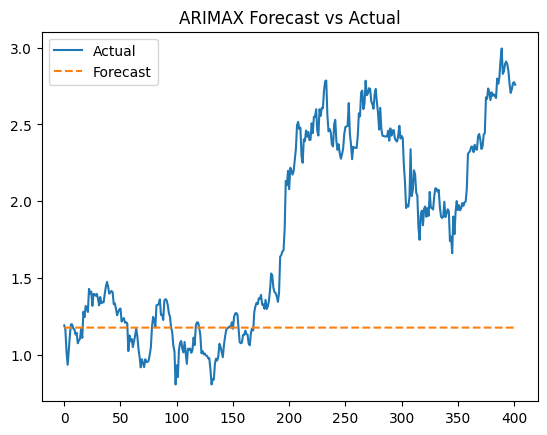

In [ ]:
import matplotlib.pyplot as plt

# Define endog_test
# Assuming train_size is the split point defined previously
endog_test = raw_df['Close'].iloc[train_size:]


plt.plot(range(len(endog_test)), endog_test, label='Actual')
plt.plot(range(len(forecast)), forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("ARIMAX Forecast vs Actual")
plt.show()

In [ ]:
# forecast_30_sarima_recursive = recursive_sarima_forecast(
#     endog_train=endog_train,
#     model_order=best_order,
#     seasonal_order=(1,0,1,7),
#     n_days=30
# )

# true_real = raw_df['Close'].iloc[train_size:train_size+30].values


In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# def rolling_sarima_forecast(data, window_size, step_size, forecast_horizon,
#                              model_order=(1,1,1), seasonal_order=(1,0,1,7)):
#     """
#     Generate rolling SARIMA forecasts.

#     Parameters:
#     - data: pandas Series (e.g., Close prices)
#     - window_size: number of days used to train SARIMA each time
#     - step_size: how many days to slide forward each iteration
#     - forecast_horizon: how many days to forecast in each step
#     """
#     all_forecasts = []
#     forecast_dates = []

#     for start in range(0, len(data) - window_size - forecast_horizon + 1, step_size):
#         end = start + window_size
#         train = data.iloc[start:end]

#         # Fit SARIMA model
#         model = SARIMAX(train, order=model_order, seasonal_order=seasonal_order,
#                         enforce_stationarity=False, enforce_invertibility=False)
#         result = model.fit(disp=False)

#         # Forecast next block
#         forecast = result.forecast(steps=forecast_horizon)
#         all_forecasts.append(forecast)
#         forecast_dates.append(forecast.index)

#     return all_forecasts, forecast_dates


In [ ]:
# # Parameters
# window_size = 365       # 1 year of training data
# step_size = 30          # slide every 30 days
# forecast_horizon = 30   # forecast 30 days

# # Apply rolling forecast
# rolling_forecasts, forecast_dates = rolling_sarima_forecast(
#     data=raw_df['Close'],
#     window_size=window_size,
#     step_size=step_size,
#     forecast_horizon=forecast_horizon,
#     model_order=best_order,
#     seasonal_order=(1,0,1,7)
# )


In [ ]:
# plt.figure(figsize=(15, 7))
# plt.plot(raw_df['Close'], label='Actual')

# # Overlay each forecast block
# for forecast in rolling_forecasts:
#     plt.plot(forecast.index, forecast.values, linestyle='--', alpha=0.7)

# plt.title('Rolling 30-Day SARIMA Forecasts')
# plt.xlabel('Date')
# plt.ylabel('BTC Price')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# days = np.arange(1, 31)
# plt.figure(figsize=(10, 5))
# plt.plot(days, true_real, label='Actual', linewidth=2)
# plt.plot(days, forecast_30_sarima_recursive, label='SARIMAX (Recursive)', linestyle='--', marker='^')
# plt.title("Recursive SARIMAX 30-Day Forecast")
# plt.xlabel("Days Ahead")
# plt.ylabel("BTC Close Price (USD)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np # Ensure numpy is imported for sqrt

# # Calculate MSE first
# arimax_30_mse = mean_squared_error(true_real, forecast_30_sarima_recursive)

# # Calculate RMSE by taking the square root of MSE
# arimax_30_rmse = np.sqrt(arimax_30_mse)

# arimax_30_mae = mean_absolute_error(true_real, forecast_30_sarima_recursive)
# print(f"ARIMAX (30-day) RMSE: {arimax_30_rmse:.2f}, MAE: {arimax_30_mae:.2f}")

**Summary Plot**

In [ ]:
# # Denormalize y_true and test_pred
# lstm_y_true_full = np.zeros((len(lstm_y_true), 5))
# lstm_test_pred_full = np.zeros((len(lstm_test_pred), 5))

# lstm_y_true_full[:, 3] = lstm_y_true.flatten()
# lstm_test_pred_full[:, 3] = lstm_test_pred.flatten()

# lstm_y_true_real = scaler.inverse_transform(lstm_y_true_full)[:, 3]
# lstm_test_pred_real = scaler.inverse_transform(lstm_test_pred_full)[:, 3]

# # Calculate MSE and then take the square root for RMSE
# # The 'squared' parameter is not supported in this sklearn version
# lstm_rmse = np.sqrt(mean_squared_error(lstm_y_true_real, lstm_test_pred_real))
# lstm_mae = mean_absolute_error(lstm_y_true_real, lstm_test_pred_real)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# days = np.arange(1, 31)

# plt.figure(figsize=(12, 6))
# plt.plot(days, true_real, label="Actual", color="black", linewidth=2)
# plt.plot(days, forecast_real, label="Neural ODE", linestyle='--', marker='o')
# plt.plot(days, lstm_forecast_real, label="LSTM", linestyle='--', marker='s')
# plt.plot(days, forecast_30_sarima_recursive, label="ARIMAX (Seasonal)", linestyle='--', marker='^')

# plt.title("30-Day Forecast Comparison")
# plt.xlabel("Day")
# plt.ylabel("BTC Close Price (USD)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(10, 4))
# plt.plot(forecast_30, label='Forecasted Close (Normalized)', marker='o')
# plt.title('30-Day Forecast Using Neural ODE')
# plt.xlabel('Day')
# plt.ylabel('Predicted Close (normalized)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# models = ['Neural ODE', 'LSTM', 'ARIMAX']
# rmses = [neural_ode_30_rmse, lstm_30_rmse, arimax_30_rmse]
# maes = [neural_ode_30_mae, lstm_30_mae, arimax_30_mae]

# plt.figure(figsize=(8, 4))
# x = np.arange(len(models))
# width = 0.35
# plt.bar(x - width/2, rmses, width, label='RMSE')
# plt.bar(x + width/2, maes, width, label='MAE')
# plt.xticks(x, models)
# plt.title('30-Day Forecast Accuracy (USD)')
# plt.ylabel('Error (USD)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# days = np.arange(1, 31)

# plt.figure(figsize=(12, 5))
# plt.plot(days, true_real, label='Actual', color='black', linewidth=2)
# plt.plot(days, forecast_real, label='Neural ODE', linestyle='--', marker='o')
# plt.plot(days, lstm_forecast_real, label='LSTM', linestyle='--', marker='s')
# plt.plot(days, forecast_30_sarima_recursive, label='ARIMAX', linestyle='--', marker='^')

# plt.title('30-Day Forecast: Predicted vs Actual BTC Close Price')
# plt.xlabel('Days into Future')
# plt.ylabel('BTC Price (USD)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_features_scaled = scaled_df[['Open', 'High', 'Low', 'Close']].copy()
seq_len = 30
forecast_horizon = 30
step_size = 30

ode_rolling_preds = []
ode_rolling_dates = []

last_true_close = None
last_pred_close = None

for i in range(0, len(test_dates) - forecast_horizon + 1, forecast_horizon):
    train_end = train_size + i
    if train_end - seq_len < 0 or train_end + forecast_horizon > len(all_features_scaled):
        continue

    input_seq = all_features_scaled.iloc[train_end - seq_len : train_end].values

    # Bias correction
    if last_true_close is not None and last_pred_close is not None:
        bias = last_true_close - last_pred_close
    else:
        bias = 0

    pred_seq = []

    for step in range(forecast_horizon):
        if train_end + step >= len(all_features_scaled):
            break

        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]

        # Apply decaying bias
        pred += bias

        pred_seq.append(pred)

        next_input = input_seq[-1].copy()
        next_input = input_seq[-1].copy()
        next_input[3] = pred  # Always use prediction
        input_seq = np.vstack([input_seq[1:], next_input])

    last_true_close = all_features_scaled.iloc[train_end + forecast_horizon - 1]['Close']
    last_pred_close = pred_seq[-1] - bias

    ode_rolling_preds.append(np.array(pred_seq))
    ode_rolling_dates.append(test_dates[i:i + forecast_horizon])


In [ ]:

# forecast_horizon_7 = 7
# step_size_7 = 7

# ode_rolling_preds_7 = []
# ode_rolling_dates_7 = []

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, forecast_horizon_7):
#     train_end = train_size + i
#     # Get the input window and convert it to a NumPy array immediately
#     X_input_np = all_features_scaled[train_end - seq_len:train_end].values

#     pred_seq = []
#     # Start with the NumPy array version
#     input_seq = X_input_np.copy()

#     for _ in range(forecast_horizon_7):
#         # input_seq is now a NumPy array, so this conversion works
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]
#         pred_seq.append(pred)

#         next_input = input_seq[-1].copy()
#         next_input[3] = pred
#         # np.vstack keeps it a NumPy array
#         input_seq = np.vstack([input_seq[1:], next_input])

#     # pred_full = np.zeros((forecast_horizon_7, 4))
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     ode_rolling_preds_7.append(np.array(pred_seq))
#     ode_rolling_dates_7.append(test_dates[i:i + forecast_horizon_7])

In [ ]:

# forecast_horizon_1 = 1
# step_size_1 = 1

# ode_rolling_preds_1 = []
# ode_rolling_dates_1 = []

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     train_end = train_size + i

#     # Input window for prediction (as NumPy array)
#     X_input_np = all_features_scaled[train_end - seq_len:train_end].values

#     pred_seq = []
#     input_seq = X_input_np.copy()

#     for _ in range(forecast_horizon_1):
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]
#         pred_seq.append(pred)

#         # Prepare the next input (only 1 step here)
#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # Replace 'Close' with prediction
#         input_seq = np.vstack([input_seq[1:], next_input])

#     # If you want denormalization later:
#     # pred_full = np.zeros((forecast_horizon_1, 5))
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     ode_rolling_preds_1.append(np.array(pred_seq))
#     ode_rolling_dates_1.append(test_dates[i:i + forecast_horizon_1])


In [ ]:

# forecast_horizon_90 = 90
# step_size_90 = 90  # optional: can use smaller stride if overlapping windows are desired

# ode_rolling_preds_90 = []
# ode_rolling_dates_90 = []

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, step_size_90):
#     train_end = train_size + i
#     X_input_np = all_features_scaled[train_end - seq_len:train_end].values  # NumPy array

#     pred_seq = []
#     input_seq = X_input_np.copy()

#     for _ in range(forecast_horizon_90):
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]
#         pred_seq.append(pred)

#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # assuming 'Close' is at index 3
#         input_seq = np.vstack([input_seq[1:], next_input])  # slide window

#     # Optional: denormalize if needed
#     # pred_full = np.zeros((forecast_horizon_90, 4))  # adjust columns to match your scaler
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.i_

#     ode_rolling_preds_90.append(np.array(pred_seq))
#     ode_rolling_dates_90.append(test_dates[i:i + forecast_horizon_90])


In [ ]:
# seq_len = 30

lstm_rolling_preds = []
lstm_rolling_dates = []

for i in range(0, len(test_dates) - forecast_horizon + 1, forecast_horizon):
    train_end = train_size + i
    # Ensure X_input is converted to numpy array
    X_input = all_features_scaled[train_end - seq_len:train_end].values  # <--- Convert to NumPy array

    pred_seq = []
    # input_seq is now a NumPy array
    input_seq = X_input.copy()

    for _ in range(forecast_horizon):
        # input_seq is a NumPy array, safe to convert to tensor
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]

        pred_seq.append(pred)

        # Append the prediction to the input sequence for next step
        next_input = input_seq[-1].copy()
        next_input[3] = pred
        # np.vstack returns a NumPy array, so input_seq remains a NumPy array
        input_seq = np.vstack([input_seq[1:], next_input])  # slide window

    # Inverse transform
    # pred_full = np.zeros((forecast_horizon, 5))
    # pred_full[:, 3] = pred_seq
    # pred_real = scaler.inverse_transform(pred_full)[:, 3]

    lstm_rolling_preds.append(np.array(pred_seq))
    lstm_rolling_dates.append(test_dates[i:i + forecast_horizon])

In [ ]:
# lstm_rolling_preds_7 = []
# lstm_rolling_dates_7 = []

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, forecast_horizon_7):
#     train_end = train_size + i
#     # Get the input window and convert it to a NumPy array immediately
#     # Explicitly convert the DataFrame slice to a NumPy array
#     X_input_np = all_features_scaled[train_end - seq_len:train_end].values

#     pred_seq = []
#     # Start with the NumPy array version
#     input_seq = X_input_np.copy() # input_seq is now a NumPy array

#     for _ in range(forecast_horizon_7):
#         # input_seq is now a NumPy array, so this conversion works
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]
#         pred_seq.append(pred)

#         # Prepare the next day's input (as a NumPy array)
#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # Update Close (index 3)
#         # np.vstack keeps it a NumPy array
#         input_seq = np.vstack([input_seq[1:], next_input])

#     # Inverse transform
#     # pred_full = np.zeros((forecast_horizon_7, 4))
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     lstm_rolling_preds_7.append(np.array(pred_seq))
#     lstm_rolling_dates_7.append(test_dates[i:i + forecast_horizon_7])

In [ ]:
# forecast_horizon_1 = 1
# step_size_1 = 1

# lstm_rolling_preds_1 = []
# lstm_rolling_dates_1 = []

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     train_end = train_size + i
#     X_input_np = all_features_scaled[train_end - seq_len:train_end].values

#     pred_seq = []
#     input_seq = X_input_np.copy()

#     for _ in range(forecast_horizon_1):
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]
#         pred_seq.append(pred)

#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # Replace 'Close' value
#         input_seq = np.vstack([input_seq[1:], next_input])

#     # Optional: denormalization logic can go here
#     # pred_full = np.zeros((forecast_horizon_1, 5))
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     lstm_rolling_preds_1.append(np.array(pred_seq))
#     lstm_rolling_dates_1.append(test_dates[i:i + forecast_horizon_1])


In [ ]:
# forecast_horizon_90 = 90
# step_size_90 = 90  # Optional: use smaller value for overlapping windows

# lstm_rolling_preds_90 = []
# lstm_rolling_dates_90 = []

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, step_size_90):
#     train_end = train_size + i
#     X_input_np = all_features_scaled[train_end - seq_len:train_end].values  # Convert to NumPy array

#     pred_seq = []
#     input_seq = X_input_np.copy()

#     for _ in range(forecast_horizon_90):
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]
#         pred_seq.append(pred)

#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # Update 'Close' at index 3
#         input_seq = np.vstack([input_seq[1:], next_input])

#     # Optional: denormalize
#     # pred_full = np.zeros((forecast_horizon_90, 4))  # adjust if you scaled more columns
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     lstm_rolling_preds_90.append(np.array(pred_seq))
#     lstm_rolling_dates_90.append(test_dates[i:i + forecast_horizon_90])


In [ ]:
sarima_rolling_preds = []
sarima_rolling_dates = []

for i in range(0, len(test_dates) - forecast_horizon + 1, step_size):
    train_end = train_size + i
    train_series = scaled_df['Close'].iloc[:train_end]  # use scaled close

    # Reindex to avoid warnings or errors
    train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')

    try:
        model = sm.tsa.SARIMAX(
            train_series,
            order=best_order,
            seasonal_order=(1, 0, 1, 30),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False)
        forecast = fitted_model.forecast(steps=forecast_horizon)

        if forecast.isnull().all() or (forecast == 0).all():
            print(f"[Warning] Forecast at step {i} is all zeros or NaNs")

        # dummy = np.zeros((len(forecast), 4))  # assuming you scaled 5 columns
        # dummy[:, 3] = forecast.values  # index 3 = 'Close'
        # forecast_real = scaler.inverse_transform(dummy)[:, 3]

        sarima_rolling_preds.append(forecast.values)
        sarima_rolling_dates.append(test_dates[i:i + forecast_horizon])
    except Exception as e:
        print(f"[Error] SARIMA failed at step {i}: {e}")
        continue


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# sarima_rolling_preds_7 = []
# sarima_rolling_dates_7 = []

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, step_size_7):
#     train_end = train_size + i
#     train_series = scaled_df['Close'].iloc[:train_end]  # use scaled close

#     # Reindex to avoid warnings or errors
#     train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')

#     try:
#         model = sm.tsa.SARIMAX(
#             train_series,
#             order=best_order,
#             seasonal_order=(1, 0, 1, 30),
#             enforce_stationarity=False,
#             enforce_invertibility=False
#         )
#         fitted_model = model.fit(disp=False)
#         forecast = fitted_model.forecast(steps=forecast_horizon_7)

#         if forecast.isnull().all() or (forecast == 0).all():
#             print(f"[Warning] Forecast at step {i} is all zeros or NaNs")

#         # dummy = np.zeros((len(forecast), 4))  # assuming you scaled 5 columns
#         # dummy[:, 3] = forecast.values  # index 3 = 'Close'
#         # forecast_real = scaler.inverse_transform(dummy)[:, 3]

#         sarima_rolling_preds_7.append(forecast.values)
#         sarima_rolling_dates_7.append(test_dates[i:i + forecast_horizon_7])
#     except Exception as e:
#         print(f"[Error] SARIMA failed at step {i}: {e}")
#         continue


In [ ]:
# forecast_horizon_1 = 1
# step_size_1 = 1

# sarima_rolling_preds_1 = []
# sarima_rolling_dates_1 = []

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     train_end = train_size + i
#     train_series = scaled_df['Close'].iloc[:train_end]  # Use scaled close

#     # Reindex to daily to ensure compatibility with SARIMAX
#     train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')

#     try:
#         model = sm.tsa.SARIMAX(
#             train_series,
#             order=best_order,
#             seasonal_order=(1, 0, 1, 7),
#             enforce_stationarity=False,
#             enforce_invertibility=False
#         )
#         fitted_model = model.fit(disp=False)
#         forecast = fitted_model.forecast(steps=forecast_horizon_1)

#         if forecast.isnull().all() or (forecast == 0).all():
#             print(f"[Warning] Forecast at step {i} is all zeros or NaNs")

#         # Optional inverse transform
#         # dummy = np.zeros((forecast_horizon_1, 5))
#         # dummy[:, 3] = forecast.values
#         # forecast_real = scaler.inverse_transform(dummy)[:, 3]

#         sarima_rolling_preds_1.append(forecast.values)
#         sarima_rolling_dates_1.append(test_dates[i:i + forecast_horizon_1])
#     except Exception as e:
#         print(f"[Error] SARIMA failed at step {i}: {e}")
#         continue


In [ ]:
# forecast_horizon_90 = 90
# step_size_90 = 90  # You can reduce this for overlapping forecasts

# sarima_rolling_preds_90 = []
# sarima_rolling_dates_90 = []

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, step_size_90):
#     train_end = train_size + i
#     train_series = scaled_df['Close'].iloc[:train_end]  # Scaled Close prices

#     # Reindex for SARIMAX compatibility
#     train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')

#     try:
#         model = sm.tsa.SARIMAX(
#             train_series,
#             order=best_order,
#             seasonal_order=(1, 0, 1, 7),
#             enforce_stationarity=False,
#             enforce_invertibility=False
#         )
#         fitted_model = model.fit(disp=False)
#         forecast = fitted_model.forecast(steps=forecast_horizon_90)

#         if forecast.isnull().all() or (forecast == 0).all():
#             print(f"[Warning] Forecast at step {i} is all zeros or NaNs")

#         # Optional: denormalize
#         # dummy = np.zeros((len(forecast), 4))  # adjust based on your scaling setup
#         # dummy[:, 3] = forecast.values  # 3 = 'Close'
#         # forecast_real = scaler.inverse_transform(dummy)[:, 3]

#         sarima_rolling_preds_90.append(forecast.values)
#         sarima_rolling_dates_90.append(test_dates[i:i + forecast_horizon_90])
#     except Exception as e:
#         print(f"[Error] SARIMA failed at step {i}: {e}")
#         continue


In [ ]:
# plt.figure(figsize=(12, 6)) # You might want to set figure size before plotting

# # SARIMAX (already plotted)
# for pred, dates in zip(sarima_rolling_preds, sarima_rolling_dates):
#     plt.plot(dates, pred, color='orange', linestyle='--', alpha=0.7)
# plt.plot([], [], color='orange', linestyle='--', label='SARIMA Rolling Forecasts')

# # LSTM
# for pred, dates in zip(lstm_rolling_preds, lstm_rolling_dates):
#     plt.plot(dates, pred, color='blue', linestyle='--', alpha=0.7)
# plt.plot([], [], color='blue', linestyle='--', label='LSTM Rolling Forecasts')

# # Neural ODE
# for pred, dates in zip(ode_rolling_preds, ode_rolling_dates):
#     plt.plot(dates, pred, color='green', linestyle='--', alpha=0.7)
# plt.plot([], [], color='green', linestyle='--', label='Neural ODE Rolling Forecasts')

# full_test_true_real = raw_df['Close'].iloc[train_size:train_size + len(test_dates)].values

# plt.plot(test_dates, full_test_true_real, color='black', label='Actual')

# # Add plot settings (title, labels, legend, etc.)

# plt.title('Rolling Forecast Comparison')
# plt.xlabel('Date')
# plt.ylabel('BTC Price (USD)')
# plt.xticks(rotation=45) # Rotate dates for readability
# plt.grid(True)
# plt.legend()
# plt.tight_layout() # Adjust layout to prevent labels overlapping
# plt.show()


In [ ]:
# def mean_directional_accuracy(y_true, y_pred):
#     return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100

# mda_ode = mean_directional_accuracy(y_true_real, y_pred_real)
# mda_lstm = mean_directional_accuracy(true_real, lstm_forecast_real)
# mda_arimax = mean_directional_accuracy(true_real, forecast_30_sarima_recursive)

# print(f"MDA - Neural ODE: {mda_ode:.2f}%, LSTM: {mda_lstm:.2f}%, ARIMAX: {mda_arimax:.2f}%")


In [ ]:
# from scipy.stats import ttest_rel

# # Example: residuals from Neural ODE vs LSTM
# residuals_ode = true_real - forecast_real
# residuals_lstm = true_real - lstm_forecast_real

# t_stat, p_val = ttest_rel(residuals_ode, residuals_lstm)
# print(f"Paired t-test (Neural ODE vs LSTM): t={t_stat:.4f}, p={p_val:.4f}")



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Store denormalized and normalized true values for each 30-day window
true_rolling_denorm_30 = []
true_rolling_norm_30 = []

forecast_horizon_30 = forecast_horizon  # Should be 30
step_size_30 = step_size                # Should be 30

for i in range(0, len(test_dates) - forecast_horizon_30 + 1, step_size_30):
    start_idx = train_size + i
    end_idx = start_idx + forecast_horizon_30

    # Normalized 'Close' values (already scaled)
    true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
    true_rolling_norm_30.append(true_vals_scaled)  # ✅ Store normalized

    # Prepare dummy for inverse transformation
    true_full_window = np.zeros((len(true_vals_scaled), 4))  # 4 features assumed
    true_full_window[:, 3] = true_vals_scaled

    true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
    true_rolling_denorm_30.append(true_vals_denorm_window)


# # Store denormalized and normalized true values for each 7-day window
# true_rolling_denorm_7 = []
# true_rolling_norm_7 = []

# forecast_horizon_7 = forecast_horizon_7  # Should be 7
# step_size_7 = step_size_7                # Should be 7

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, step_size_7):
#     start_idx = train_size + i
#     end_idx = start_idx + forecast_horizon_7

#     # Normalized 'Close' values (already scaled)
#     true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
#     true_rolling_norm_7.append(true_vals_scaled)  # ✅ Store normalized

#     # Prepare dummy for inverse transformation
#     true_full_window = np.zeros((len(true_vals_scaled), 4))  # 4 features assumed
#     true_full_window[:, 3] = true_vals_scaled

#     true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
#     true_rolling_denorm_7.append(true_vals_denorm_window)

# true_rolling_denorm_1 = []
# true_rolling_norm_1 = []

# forecast_horizon_1 = 1
# step_size_1 = 1

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     start_idx = train_size + i
#     end_idx = start_idx + forecast_horizon_1

#     # Normalized 'Close' value (already scaled)
#     true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
#     true_rolling_norm_1.append(true_vals_scaled)

#     # Prepare dummy for inverse transformation (4 features assumed)
#     true_full_window = np.zeros((len(true_vals_scaled), 4))
#     true_full_window[:, 3] = true_vals_scaled

#     true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
#     true_rolling_denorm_1.append(true_vals_denorm_window)

# # Store denormalized and normalized true values for each 90-day window
# true_rolling_denorm_90 = []
# true_rolling_norm_90 = []

# forecast_horizon_90 = 90
# step_size_90 = 90  # Adjust if you want overlapping forecasts

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, step_size_90):
#     start_idx = train_size + i
#     end_idx = start_idx + forecast_horizon_90

#     # Normalized 'Close' values (already scaled)
#     true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
#     true_rolling_norm_90.append(true_vals_scaled)  # ✅ Store normalized

#     # Prepare dummy for inverse transformation (assumes 4 features)
#     true_full_window = np.zeros((len(true_vals_scaled), 4))
#     true_full_window[:, 3] = true_vals_scaled  # Assuming 'Close' is at index 3

#     # Denormalize
#     true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
#     true_rolling_denorm_90.append(true_vals_denorm_window)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_forecasts(true_rolling, model_preds, model_name="Model", seasonality=30):
    all_true = np.array(true_rolling).flatten()
    all_pred = np.array(model_preds).flatten()

    if len(all_true) == 0 or len(all_pred) == 0:
        print(f"{model_name} Evaluation: No data to evaluate.")
        return
    if len(all_true) != len(all_pred):
        print(f"Warning: Length of true values ({len(all_true)}) and predictions ({len(all_pred)}) do not match for {model_name}.")
        min_len = min(len(all_true), len(all_pred))
        all_true = all_true[:min_len]
        all_pred = all_pred[:min_len]
        print(f"  Truncating to length: {min_len}")

    mse = mean_squared_error(all_true, all_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_true, all_pred)

    # Mean Directional Accuracy
    mda = np.nan
    if len(all_true) > 1:
        direction_true = np.sign(np.diff(all_true))
        direction_pred = np.sign(np.diff(all_pred))
        non_zero_diff_mask = direction_true != 0
        if np.any(non_zero_diff_mask):
            mda = np.mean(direction_true[non_zero_diff_mask] == direction_pred[non_zero_diff_mask]) * 100

    # MASE with seasonality
    mase = np.nan
    if len(all_true) > seasonality:
        naive_forecast = all_true[:-seasonality]
        actual_values = all_true[seasonality:]
        naive_errors = np.abs(actual_values - naive_forecast)
        mae_naive = np.mean(naive_errors)
        mae_truncated = mean_absolute_error(actual_values, all_pred[seasonality:])
        mase = mae_truncated / mae_naive if mae_naive != 0 else (np.inf if mae > 0 else 0)

    print(f"{model_name} Evaluation:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  MASE: {mase:.4f}") if not np.isnan(mase) else print(f"  MASE: {mase}")
    print(f"  MDA : {mda:.2f}%") if not np.isnan(mda) else print(f"  MDA : {mda}")
    print()


In [ ]:
# true_concat = np.concatenate(true_rolling)
# true_full = np.zeros((len(true_concat), 4))
# true_full[:, 3] = true_concat
# true_denorm = scaler.inverse_transform(true_full)[:, 3]

# sarima_concat = np.concatenate(sarima_rolling_preds)
# sarima_full = np.zeros((len(sarima_concat), 4))
# sarima_full[:, 3] = sarima_concat
# sarima_denorm = scaler.inverse_transform(sarima_full)[:, 3]

# lstm_concat = np.concatenate(lstm_rolling_preds)
# lstm_full = np.zeros((len(lstm_concat), 5))
# lstm_full[:, 3] = lstm_concat
# lstm_denorm = scaler.inverse_transform(lstm_full)[:, 3]

# ode_concat = np.concatenate(ode_rolling_preds)
# ode_full = np.zeros((len(ode_concat), 5))
# ode_full[:, 3] = ode_concat
# ode_denorm = scaler.inverse_transform(ode_full)[:, 3]


In [ ]:
# file ipython-input-620-fdda98a454d1

# # Evaluate 90-day rolling forecasts using the 30-day true values
# evaluate_forecasts(true_rolling_norm_90, sarima_rolling_preds_90, model_name="SARIMAX (90-day)")
# evaluate_forecasts(true_rolling_norm_90, lstm_rolling_preds_90, model_name="LSTM (90-day)")
# evaluate_forecasts(true_rolling_norm_90, ode_rolling_preds_90, model_name="Neural ODE (90-day)")

# Evaluate 30-day rolling forecasts using the 30-day true values
evaluate_forecasts(true_rolling_norm_30, sarima_rolling_preds, model_name="SARIMAX (30-day)")
evaluate_forecasts(true_rolling_norm_30, lstm_rolling_preds, model_name="LSTM (30-day)")
evaluate_forecasts(true_rolling_norm_30, ode_rolling_preds, model_name="Neural ODE (30-day)")

# # Evaluate 7-day rolling forecasts using the 7-day true values
# evaluate_forecasts(true_rolling_norm_7, sarima_rolling_preds_7, model_name="SARIMAX (7-day)")
# evaluate_forecasts(true_rolling_norm_7, lstm_rolling_preds_7, model_name="LSTM (7-day)")
# evaluate_forecasts(true_rolling_norm_7, ode_rolling_preds_7, model_name="Neural ODE (7-day)")

# # Evaluate 1-day ahead forecast using the 7-day true values
# evaluate_forecasts(true_rolling_norm_1, sarima_rolling_preds_1, model_name="SARIMAX (1-day)")
# evaluate_forecasts(true_rolling_norm_1, lstm_rolling_preds_1, model_name="LSTM (1-day)")
# evaluate_forecasts(true_rolling_norm_1, ode_rolling_preds_1, model_name="Neural ODE (1-day)")

SARIMAX (30-day) Evaluation:
  RMSE: 0.2736
  MAE : 0.1930
  MASE: 0.6300
  MDA : 49.36%

LSTM (30-day) Evaluation:
  RMSE: 0.3169
  MAE : 0.2243
  MASE: 0.7353
  MDA : 50.64%

Neural ODE (30-day) Evaluation:
  RMSE: 0.3589
  MAE : 0.2649
  MASE: 0.8550
  MDA : 53.73%



In [ ]:
def denormalize_close(norm_close_values, scaler, features):
    """
    Denormalizes one or more normalized 'Close' values using the fitted scaler.

    Parameters:
    - norm_close_values: float or 1D numpy array of normalized close values
    - scaler: fitted StandardScaler
    - features: list of feature names used in scaling (e.g., ['Open', 'High', 'Low', 'Close', 'fgi'])

    Returns:
    - Denormalized close price(s), same shape as input
    """
    close_idx = features.index('Close')

    # Ensure input is at least 1D array
    norm_close_values = np.atleast_1d(norm_close_values)

    # Prepare full array with zeros, insert norm close at the right index
    full_window = np.zeros((len(norm_close_values), len(features)))
    full_window[:, close_idx] = norm_close_values

    # Inverse transform and return just the Close values
    denorm = scaler.inverse_transform(full_window)[:, close_idx]

    # Return scalar if input was scalar
    return denorm[0] if len(denorm) == 1 else denorm


In [ ]:
# # Denormalize "True" values
# true_rolling_denorm_1 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_1]
# true_rolling_denorm_7 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_7]
# true_rolling_denorm_30 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_30]
# true_rolling_denorm_90 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_90]

# # Denormalize all model predictions
# sarima_rolling_preds_1 = [denormalize_close(x, scaler, features) for x in sarima_rolling_preds_1]
# lstm_rolling_preds_1 = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds_1]
# ode_rolling_preds_1 = [denormalize_close(x, scaler, features) for x in ode_rolling_preds_1]

# sarima_rolling_preds_7 = [denormalize_close(x, scaler, features) for x in sarima_rolling_preds_7]
# lstm_rolling_preds_7 = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds_7]
# ode_rolling_preds_7 = [denormalize_close(x, scaler, features) for x in ode_rolling_preds_7]
sarima_rolling_preds_norm = sarima_rolling_preds.copy()
lstm_rolling_preds_norm = lstm_rolling_preds.copy()
ode_rolling_preds_norm = ode_rolling_preds.copy()

sarima_rolling_preds = [denormalize_close(x, scaler, features) for x in sarima_rolling_preds]
lstm_rolling_preds = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds]
ode_rolling_preds = [denormalize_close(x, scaler, features) for x in ode_rolling_preds]

# sarima_rolling_preds_90 = [denormalize_close(x, scaler, features) for x in sarima_rolling_preds_90]
# lstm_rolling_preds_90 = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds_90]
# ode_rolling_preds_90 = [denormalize_close(x, scaler, features) for x in ode_rolling_preds_90]


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def prepare_for_plot(data_list):
#     """Converts a list of scalars or arrays into a single 1D numpy array for plotting."""
#     return np.concatenate([np.atleast_1d(item) for item in data_list])

# # Set up a 2x2 grid for 4 subplots
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# fig.suptitle('Rolling Forecasts vs True Values (Denormalized)', fontsize=16)

# # Horizon: 1-day
# axs[0, 0].plot(prepare_for_plot(sarima_rolling_dates_1), prepare_for_plot(true_rolling_denorm_1), label='True', color='black')
# axs[0, 0].plot(prepare_for_plot(sarima_rolling_dates_1), prepare_for_plot(sarima_rolling_preds_1), label='SARIMA', color='red')
# axs[0, 0].plot(prepare_for_plot(lstm_rolling_dates_1), prepare_for_plot(lstm_rolling_preds_1), label='LSTM', color='blue')
# axs[0, 0].plot(prepare_for_plot(ode_rolling_dates_1), prepare_for_plot(ode_rolling_preds_1), label='Neural ODE', color='yellow')
# axs[0, 0].set_title('1-Day Forecast')
# axs[0, 0].legend()
# axs[0, 0].grid(True)

# # Horizon: 7-day
# axs[0, 1].plot(prepare_for_plot(sarima_rolling_dates_7), prepare_for_plot(true_rolling_denorm_7), label='True', color='black')
# axs[0, 1].plot(prepare_for_plot(sarima_rolling_dates_7), prepare_for_plot(sarima_rolling_preds_7), label='SARIMA', color='red')
# axs[0, 1].plot(prepare_for_plot(lstm_rolling_dates_7), prepare_for_plot(lstm_rolling_preds_7), label='LSTM', color='blue')
# axs[0, 1].plot(prepare_for_plot(ode_rolling_dates_7), prepare_for_plot(ode_rolling_preds_7), label='Neural ODE', color='yellow')
# axs[0, 1].set_title('7-Day Forecast')
# axs[0, 1].legend()
# axs[0, 1].grid(True)

# # Horizon: 30-day
# axs[1, 0].plot(prepare_for_plot(sarima_rolling_dates), prepare_for_plot(true_rolling_denorm_30), label='True', color='black')
# axs[1, 0].plot(prepare_for_plot(sarima_rolling_dates), prepare_for_plot(sarima_rolling_preds), label='SARIMA', color='red')
# axs[1, 0].plot(prepare_for_plot(lstm_rolling_dates), prepare_for_plot(lstm_rolling_preds), label='LSTM', color='blue')
# axs[1, 0].plot(prepare_for_plot(ode_rolling_dates), prepare_for_plot(ode_rolling_preds), label='Neural ODE', color='yellow')
# axs[1, 0].set_title('30-Day Forecast')
# axs[1, 0].legend()
# axs[1, 0].grid(True)

# # Horizon: 90-day
# axs[1, 1].plot(prepare_for_plot(sarima_rolling_dates_90), prepare_for_plot(true_rolling_denorm_90), label='True', color='black')
# axs[1, 1].plot(prepare_for_plot(sarima_rolling_dates_90), prepare_for_plot(sarima_rolling_preds_90), label='SARIMA', color='red')
# axs[1, 1].plot(prepare_for_plot(lstm_rolling_dates_90), prepare_for_plot(lstm_rolling_preds_90), label='LSTM', color='blue')
# axs[1, 1].plot(prepare_for_plot(ode_rolling_dates_90), prepare_for_plot(ode_rolling_preds_90), label='Neural ODE', color='yellow')
# axs[1, 1].set_title('90-Day Forecast')
# axs[1, 1].legend()
# axs[1, 1].grid(True)

# # Final layout
# for ax in axs.flat:
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Close Price')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
# plt.show()


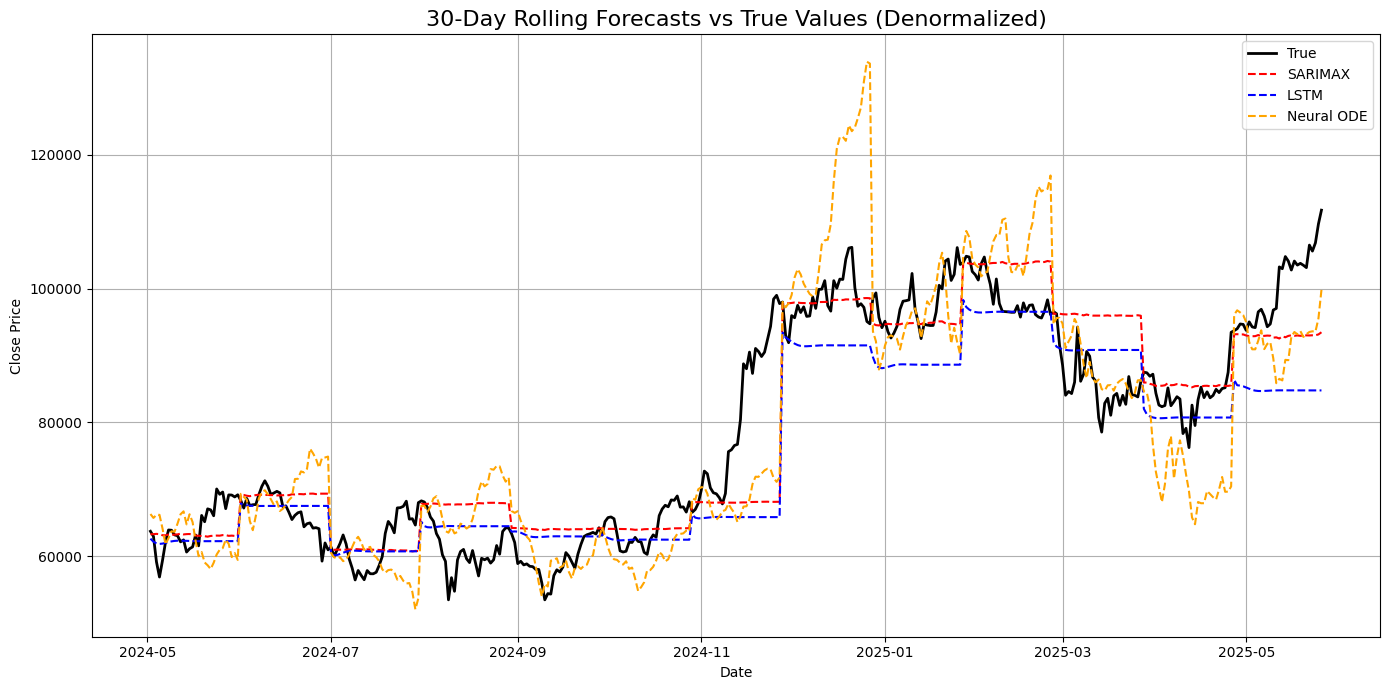

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_for_plot(data_list):
    """Converts a list of scalars or arrays into a single 1D numpy array for plotting."""
    return np.concatenate([np.atleast_1d(item) for item in data_list])

plt.figure(figsize=(14, 7))
plt.title('30-Day Rolling Forecasts vs True Values (Denormalized)', fontsize=16)

# Plot true values
plt.plot(prepare_for_plot(sarima_rolling_dates), prepare_for_plot(true_rolling_denorm_30),
         label='True', color='black', linewidth=2)

# Plot SARIMAX predictions
plt.plot(prepare_for_plot(sarima_rolling_dates), prepare_for_plot(sarima_rolling_preds),
         label='SARIMAX', color='red', linestyle='--')

# Plot LSTM predictions
plt.plot(prepare_for_plot(lstm_rolling_dates), prepare_for_plot(lstm_rolling_preds),
         label='LSTM', color='blue', linestyle='--')

# Plot Neural ODE predictions
plt.plot(prepare_for_plot(ode_rolling_dates), prepare_for_plot(ode_rolling_preds),
         label='Neural ODE', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Save each prepared series
def save_series_to_csv(series, filename):
    array_1d = prepare_for_plot(series)
    pd.Series(array_1d).to_csv(filename, index=False)

save_series_to_csv(true_rolling_denorm_30, "true_rolling_denorm_30_nofgi.csv")
save_series_to_csv(sarima_rolling_preds,    "sarima_preds_30_nofgi.csv")
save_series_to_csv(lstm_rolling_preds,    "lstm_preds_30_nofgi.csv")
save_series_to_csv(ode_rolling_preds,    "ode_preds_30_nofgi.csv")
save_series_to_csv(true_rolling_norm_30, "true_rolling_norm_30_nofgi.csv")
save_series_to_csv(sarima_rolling_preds_norm, "sarima_preds_norm_30_nofgi.csv")
save_series_to_csv(lstm_rolling_preds_norm, "lstm_preds_norm_30_nofgi.csv")
save_series_to_csv(ode_rolling_preds_norm, "ode_preds_norm_30_nofgi.csv")


In [ ]:
# import pandas as pd

# # Save each prepared series
# def save_series_to_csv(series, filename):
#     array_1d = prepare_for_plot(series)
#     pd.Series(array_1d).to_csv(filename, index=False)

# # Save the true values
# save_series_to_csv(true_rolling_denorm_7, "true_rolling_norm_7.csv")
# save_series_to_csv(true_rolling_denorm_30, "true_rolling_norm_30.csv")
# save_series_to_csv(true_rolling_denorm_90, "true_rolling_norm_90.csv")
# save_series_to_csv(true_rolling_denorm_1, "true_rolling_norm_1.csv")

# # Save SARIMAX forecasts
# save_series_to_csv(sarima_rolling_preds_90, "sarimax_preds_90.csv")
# save_series_to_csv(sarima_rolling_preds,    "sarimax_preds_30.csv")
# save_series_to_csv(sarima_rolling_preds_7,  "sarimax_preds_7.csv")
# save_series_to_csv(sarima_rolling_preds_1,  "sarimax_preds_1.csv")

# # Save LSTM forecasts
# save_series_to_csv(lstm_rolling_preds_90, "lstm_preds_90.csv")
# save_series_to_csv(lstm_rolling_preds,    "lstm_preds_30.csv")
# save_series_to_csv(lstm_rolling_preds_7,  "lstm_preds_7.csv")
# save_series_to_csv(lstm_rolling_preds_1,  "lstm_preds_1.csv")

# # Save Neural ODE forecasts
# save_series_to_csv(ode_rolling_preds_90, "ode_preds_90.csv")
# save_series_to_csv(ode_rolling_preds,    "ode_preds_30.csv")
# save_series_to_csv(ode_rolling_preds_7,  "ode_preds_7.csv")
# save_series_to_csv(ode_rolling_preds_1,  "ode_preds_1.csv")


In [ ]:
# from statsmodels.tsa.stattools import grangercausalitytests

# # Use original merged data and enforce strict dropna AFTER setting frequency
# granger_data = merged_df[['Close', 'fgi']].copy()
# granger_data.index = pd.DatetimeIndex(granger_data.index)
# granger_data = granger_data.asfreq('D')  # Fill in missing days
# granger_data.dropna(inplace=True)        # Remove rows with NaNs

# # Confirm there are no NaNs or infs
# assert not granger_data.isna().any().any(), "Still contains NaNs"
# assert np.isfinite(granger_data.values).all(), "Still contains infs"

# # Run Granger causality test
# grangercausalitytests(granger_data[['Close', 'fgi']], maxlag=5, verbose=True)


In [ ]:
# class ODEFunc(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(ODEFunc, self).__init__()
#         self.input_layer = nn.Linear(input_dim, hidden_dim)
#         self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)

#     def forward(self, t, h):
#         h = torch.tanh(self.input_layer(h))
#         return self.hidden_layer(h)

# class NeuralODE(nn.Module):
#     def __init__(self, ode_func):
#         super(NeuralODE, self).__init__()
#         self.ode_func = ode_func

#     def forward(self, h0, t):
#         return odeint(self.ode_func, h0, t)